# Chapter 7
## Moving Beyond Linearity

Relaxing the linearity assumption while still maintaining as much interpretibility as possible.

__1. Polynomial Regression__ :- Extends the linear model by adding extra predictors, obtained by raising each of the original predictors to a power.


__2. Step Functions__ :- Cut the range of a variable into K distinct regions in order to produce a qualitative variable. This has the effect of fitting a piecewise constant function.


__3. Regression Splines__ :- Dividing a variable to K distinct regions. Within each region, a polynomial is fit to data. The polynomial join smoothly at region boundaries called knots. 


__4. Smoothing Splines__ :- They result from minimizing a RSS criterion subject to smoothness penalty.


__5. Local Regression__ :- Similar to splines but the region are allowed to overlap.


__6. Generalized Additive Models__ :- Extend the above method to deal with multiple predictors.

### Polynomial Regression 
A polynomial regression model can be written as 
$$y_i = \beta_0 + \beta_1 x_{i} +  \beta_2 x_{i}^{2} +....+ \beta_d x_{i}^{d} + \epsilon_i$$
$\epsilon_i$ = error term.

large value of d means more flexible curve especially near the boundary of X. hence it is unusual to use d greater than 3 or 4. 

The coefficients can be estimated using least squares. Least squares returns varaince estimates for each fitted coefficients $\hat \beta_j$

If $l_o$ is the point estimate = $(1,x_0,x_{0}^{2},..)$ and C is the covaraince matrix then pointwise standard error can be written as $l_{0}^{T}Cl_0$.
This can be used to estimate the CI.


In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as stats
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [113]:
# Readin wage data in our environment.
url = "https://raw.githubusercontent.com/atystats/ISLR_Notes_codes/master/Datasets/Wage.csv"
Wage = pd.read_csv(url, index_col = 0, error_bad_lines = False)
Wage["Wage_250"] = 0
Wage.loc[Wage.wage > 250, "Wage_250"] = 1 # Creating binary variable for logistic model

In [114]:
X = np.array(Wage["age"]).reshape(-1,1)
y = np.array(Wage["wage"])
polynomial_features= PolynomialFeatures(degree=4)
xp = polynomial_features.fit_transform(X)

model = sm.OLS(y,xp).fit() # Fitting a linear model with polynomial terms

y = np.array(Wage["Wage_250"])
logit_model = sm.Logit(y,xp).fit() # Fitting a logistic regression model with polynomial terms


Optimization terminated successfully.
         Current function value: 0.116870
         Iterations 12


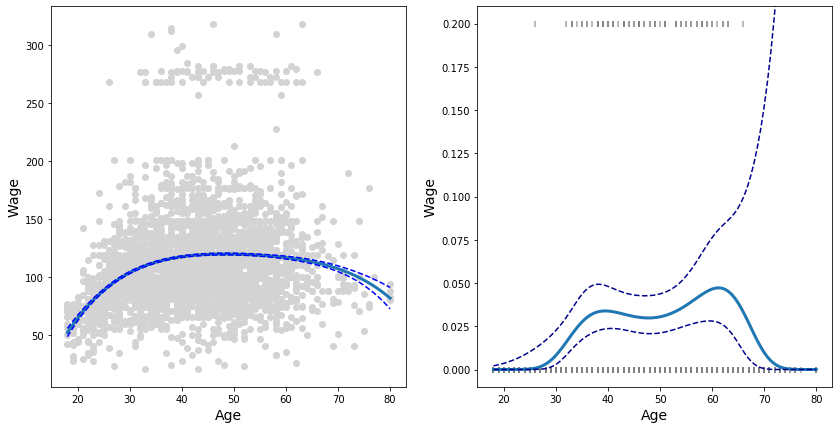

In [115]:
age_lin = np.linspace(min(Wage.age), max(Wage.age), 100)
age_poly = polynomial_features.fit_transform(age_lin.reshape(-1,1))

prediction = model.get_prediction(age_poly) # Getting the prediction interval for the linear model
CI = prediction.summary_frame(alpha = 0.5)

fig = plt.figure(figsize = (14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(Wage.age, Wage.wage, color = "lightgrey")
ax1.plot(age_lin, model.predict(age_poly), linewidth = 3.0)
ax1.plot(age_lin, CI.mean_ci_lower, linestyle = "--", color = "blue")
ax1.plot(age_lin, CI.mean_ci_upper, linestyle = "--", color = "blue")
ax1.set_xlabel("Age", fontsize = 14)
ax1.set_ylabel("Wage", fontsize = 14)

# Prediction interval for the logistic regression model.
l0 = np.dot(age_poly,logit_model.params)
std_error = np.array([np.sqrt(np.dot(np.dot(g,logit_model.cov_params()),g)) for g in age_poly])
upper = l0 + 2 * std_error
lower = l0 - 2 * std_error
upper = np.exp(upper)/(1 + np.exp(upper))
lower = np.exp(lower)/(1 + np.exp(lower))

ax2 = fig.add_subplot(122)
ax2.scatter(Wage.age, Wage.Wage_250/5, color = "grey", marker = "|", alpha = 0.7)
ax2.plot(age_lin, logit_model.predict(age_poly), linewidth = 3.0)
ax2.plot(age_lin, lower, linestyle = "--", color = "darkblue")
ax2.plot(age_lin, upper, linestyle = "--", color = "darkblue")
ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel("Age", fontsize = 14)
ax2.set_ylabel("Wage", fontsize = 14)
plt.show()

The above plot shows how the prediction interval becomes wider at the edge of X variable. This happens because the at the extremes there are usually less observations and hence high variance in the estimates also the polynomial regression impose a global structure on the function of X so we can't control the shape where there is less no. of data.

### Step Functions
Step function breaks X into bins and fit a different constant in each bin. This amounts to converting a continous variable into ordered categorical variable. 

We create cut points $c_1,c_2, ... ,c_k$ in range of X, then construct K+1 new variables.
$$C_0(X) = I(X<c_1)$$
$$C_1(X) = I(c_1\le X\le c_2)$$
$$C_2(X) = I(c_2\le X\le c_3)$$
$$.....$$
$$C_{k-1}(X) = I(c_{k-1}\le X\le c_k)$$
$$C_k(X) = I(X \ge c_k)$$
Where I(.) = indicator function.

Finally, the linear equation can be written as 
$$y_i = \beta_0 + \beta_1 C_1(x_{i}) +  \beta_2 C_2(x_{i}) +....+ \beta_k C_k(x_{i}) + \epsilon_i$$

For X < $c_1$, all the predictors are zero so $\beta_0$ can be interpreted as mean value of Y for X < $c_1$.
$$y_i = \beta_0 + \beta_j\ \ \ for\ \ \ c_j \le X \le c_{j+1}$$
$\beta_j$ = average increase in response for X in $c_j \le X \le c_{j+1}$ relative to $X < c_1$

A similar logistic model would be 
$$P(y_i>c|x_i) = \frac{exp(\beta_0 + \beta_1 C_1(x_{i}) +  \beta_2 C_2(x_{i}) +....+ \beta_k C_k(x_{i}))}{1 + exp(\beta_0 + \beta_1 C_1(x_{i}) +  \beta_2 C_2(x_{i}) +....+ \beta_k C_k(x_{i}))}$$

However, selecting bins can be challenging unless there are natural breakpoints in predictors.

In [116]:
# Creating new variable with cut points at 30,50 and 65.
Wage["Age_30_50"] = 0
Wage.loc[(Wage.age > 30) & (Wage.age < 50), "Age_30_50"] = 1
Wage["Age_50_65"] = 0
Wage.loc[(Wage.age >= 50) & (Wage.age < 65), "Age_50_65"] = 1
Wage["Age_ge_65"] = 0
Wage.loc[Wage.age >= 65, "Age_ge_65"] = 1
X = np.array(Wage[["Age_30_50","Age_50_65","Age_ge_65"]])
X = sm.add_constant(X)
y = np.array(Wage["wage"])

model = sm.OLS(y,X).fit() # Fitting a linear model with step functions

y = np.array(Wage["Wage_250"])
logit_model = sm.Logit(y,X).fit() # Fitting a logistic regression model with step functions

Optimization terminated successfully.
         Current function value: 0.117675
         Iterations 10


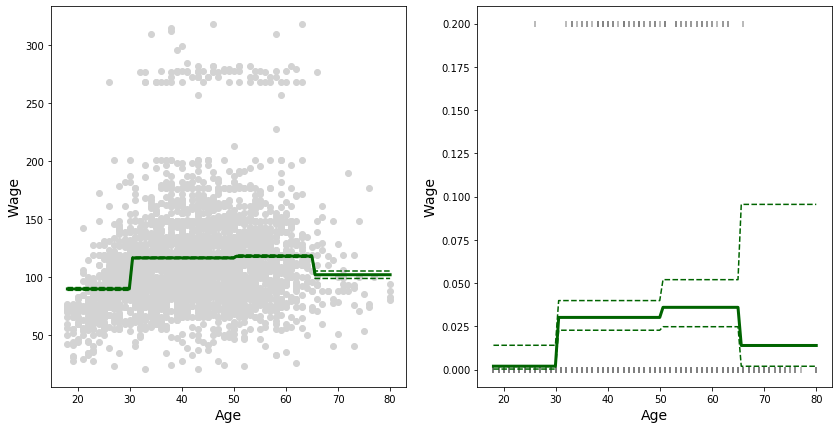

In [124]:
age = np.linspace(min(Wage.age), max(Wage.age), 100)
test_data = pd.DataFrame({"age":age})

test_data["Age_30_50"] = 0                          
test_data.loc[(test_data.age > 30) & (test_data.age < 50), "Age_30_50"] = 1
test_data["Age_50_65"] = 0
test_data.loc[(test_data.age >= 50) & (test_data.age < 65), "Age_50_65"] = 1
test_data["Age_ge_65"] = 0
test_data.loc[test_data.age >= 65, "Age_ge_65"] = 1 
test_X = np.array(test_data[["Age_30_50","Age_50_65","Age_ge_65"]])
                          
test_X = sm.add_constant(test_X)

prediction = model.get_prediction(test_X) # Getting the prediction interval for the linear model
CI = prediction.summary_frame(alpha = 0.5)

fig = plt.figure(figsize = (14,7))
ax1 = fig.add_subplot(121)
ax1.scatter(Wage.age, Wage.wage, color = "lightgrey")
ax1.plot(age, model.predict(test_X), linewidth = 3.0, color = "darkgreen")
ax1.plot(age, CI.mean_ci_lower, linestyle = "--", color = "darkgreen")
ax1.plot(age, CI.mean_ci_upper, linestyle = "--", color = "darkgreen")
ax1.set_xlabel("Age", fontsize = 14)
ax1.set_ylabel("Wage", fontsize = 14)

# Prediction interval for the logistic regression model.
l0 = np.dot(test_X,logit_model.params)
std_error = np.array([np.sqrt(np.dot(np.dot(g,logit_model.cov_params()),g)) for g in test_X])
upper = l0 + 2 * std_error
lower = l0 - 2 * std_error
upper = np.exp(upper)/(1 + np.exp(upper))
lower = np.exp(lower)/(1 + np.exp(lower))

ax2 = fig.add_subplot(122)
ax2.scatter(Wage.age, Wage.Wage_250/5, color = "grey", marker = "|", alpha = 0.7)
ax2.plot(age, logit_model.predict(test_X), linewidth = 3.0, color = "darkgreen")
ax2.plot(age, lower, linestyle = "--", color = "darkgreen")
ax2.plot(age, upper, linestyle = "--", color = "darkgreen")
ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel("Age", fontsize = 14)
ax2.set_ylabel("Wage", fontsize = 14)
plt.show()

We can see that between the cutpoints the prediction curve is flat. This is called __piecewise-constant regression__ model.

### Basis Functions
Instead of using X, use a function of X b(X) as input in the model. Polynomial and piecewise-constant regression is a special case of basis function.
$$y_i = \beta_0 + \beta_1 b_1(x_{i}) +  \beta_2 b_2(x_{i}) +....+ \beta_k b_k(x_{i}) + \epsilon_i$$

Basis function are fixed and known. We can use least squares to estimate them and hence all the inference tool for linear models can be applied.

### Regression Splines

__1. Piecewise Polynomial__ :-